Hyperparameter
- ITERS = 10000
- layers = [1,128,128,128,128,8]
- BATCH = 16
- NUM_HIDDEN = 1
- MOMENTUM = 0.8
- learning_rate = 1e-6
- lr_rate = [1e-3, 1e-4, 1e-6]
- lr_boundaries = [5000, 8000]

In [1]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as normal

tf.keras.backend.set_floatx('float64')
tf.compat.v1.enable_eager_execution()

In [2]:
NUM_OF_INTERNAL = 60
TOTAL_T = 60
NUM_HIDDEN = 1
MOMENTUM = 0.8
BATCH = 16
K = 5
ITERS = 10000
SEED = 12345
TEXT = "base_case" #change this one

c1 = 100 
c2 = 20
c3 = 50
c4 = 200
c5 = 1000
c6 = 300*1/2

In [3]:
birth =  0.000053
death =  0.000033 

alpha = 0.00135
sigma = 0.06352
beta1 = 0.2812 
beta2 = 0.15838 
beta3 = 0.0388 
delta1 = 0.28505
delta2 = 0.28269
delta3 = 0.14206
gamma = 0.30954
p1 = 0.01845
p2 = 0.1431
mu = 0.0042
sigma1 = 0.09275
sigma2 = 0.03887
sigma3 = 0.07517
sigma4 = 0.06302
sigma5 = 0.07878
sigma6 = 0.06123
sigma7 = 0.0611
sigma8 = 0.06199

N = 6629870
S0 = 3674149/N
V0 = 2845438/N
E0 = 67789/N
I10 = 12113/N
I20 = 498/N
I30 = 96/N
R0 = 28911/N
D0 = 876/N

init = [S0, V0, E0, I10, I20, I30, R0, D0]

In [4]:
k0 = 0.006
k1 = -0.1341

def p1fn(alpha):
    return k0 + k1 * alpha

In [5]:
class Solver(object):

    def __init__(self, seed_var):
        self.valid_size = BATCH
        self.batch_size = BATCH
        
        self.num_iterations = ITERS
        self.print_frequency = 100
        self.lr_values = [1e-3, 1e-4, 1e-6]
        self.lr_boundaries = [5000, 8000]
        self.config = Config()

        self.model = WholeNet(seed_var)
        lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(self.lr_boundaries, self.lr_values)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-7)

    def train(self):
        """Training the model"""
        start_time = time.time()
        training_history = []
        control_output = [] 
        
        dW = self.config.sample(self.valid_size)
        valid_data = dW
        for step in range(self.num_iterations+1):
            if step % self.print_frequency == 0:
                cost, row_out0 = self.model(valid_data, training=True)
                elapsed_time = time.time() - start_time
                training_history.append([step, cost, elapsed_time])
                print("step: %5u, Cost: %.4e, elapsed time: %3u" % (step, cost, elapsed_time))
            if step == self.num_iterations:
                cost1, row_out1 = self.model(valid_data, training=True)
                row_output = row_out1.numpy()
                control_output.append(row_output)
            self.train_step(self.config.sample(self.batch_size))
        self.training_history = training_history
        self.control_output = control_output

    @tf.function
    def train_step(self, train_data):
        """Updating the gradients"""
        with tf.GradientTape(persistent=True) as tape:
            loss = self.model(train_data, training = True)
        grad = tape.gradient(loss, self.model.trainable_variables)
        del tape
        self.optimizer.apply_gradients(zip(grad, self.model.trainable_variables))

In [6]:
class WholeNet(tf.keras.Model):
    """Building the neural network architecture"""
    def __init__(self,seed_var):
        super(WholeNet, self).__init__()
        self.config = Config()
        self.subnet = [FNNet(seed_var) for _ in range(self.config.num_time_interval)]

    def call(self, dw, training):
        x_init = tf.ones([1, self.config.dim_x], dtype=tf.dtypes.float64) * init
        time_stamp = np.arange(0, self.config.num_time_interval) * self.config.delta_t
        all_ones = tf.ones([tf.shape(dw)[0], 1], dtype=tf.dtypes.float64)

        # initial state
        x = tf.matmul(all_ones, x_init)

        # initial cost functional
        l = 0.0 
        u_set = []
        for t in range(0, self.config.num_time_interval):
            u = self.subnet[t](x, training)
            u_set.append(tf.stack([u], axis=0))   
            l = l + self.config.f_fn(time_stamp[t], x, u) * self.config.delta_t
            x = x + self.config.b_fn(time_stamp[t], x, u) * self.config.delta_t + self.config.sigma_fn(time_stamp[t], x, u) * dw[:,:,  t]

        # control variable
        control_u = tf.stack(u_set, axis=0)
        row_ave2 = tf.reduce_mean(control_u, axis=2)
        row_out1 = tf.squeeze(row_ave2, axis=[1,2])
        #print("u timepath2", row_ave2)
        
        # terminal condition
        l = l + self.config.h_fn(self.config.total_time, x)
        cost = tf.reduce_mean(l) 
        return cost, row_out1


In [7]:
class FNNet(tf.keras.Model):
    def __init__(self, seed_var):
        super(FNNet, self).__init__()
        self.config = Config()

        tf.random.set_seed(seed_var)
        np.random.seed(seed_var)
        
        num_hiddens = [self.config.dim_x + NUM_HIDDEN, self.config.dim_x + NUM_HIDDEN, self.config.dim_x + NUM_HIDDEN]
        self.bn_layers = [
            tf.keras.layers.BatchNormalization(
                momentum=MOMENTUM,
                epsilon=1e-6,
                beta_initializer=tf.random_normal_initializer(0.0, stddev=0.1,seed=seed_var),
                gamma_initializer=tf.random_uniform_initializer(0.1, 0.5,seed=seed_var)
            )
            for _ in range(len(num_hiddens) + 2)]
        self.dense_layers = [tf.keras.layers.Dense(num_hiddens[i],
                                                   use_bias=True,
                                                   activation='tanh')
                             for i in range(len(num_hiddens))]
        
        # final output should be gradient of size dim_u
        self.dense_layers.append(tf.keras.layers.Dense(self.config.dim_u, activation='sigmoid'))

    def call(self, x, training):
        x = self.bn_layers[0](x, training)
        for i in range(len(self.dense_layers) - 1):
            x = self.dense_layers[i](x)
            x = self.bn_layers[i+1](x, training)
            x = tf.nn.tanh(x)
        x = self.dense_layers[-1](x)
        x = self.bn_layers[-1](x, training)
        return tf.nn.tanh(x) * 0.012 + 0.016

In [8]:
class Config(object):
    """function config"""
    def __init__(self):
        super(Config, self).__init__()
        self.dim_x = 8
        self.dim_u = 1
        self.num_time_interval = NUM_OF_INTERNAL
        self.total_time = TOTAL_T
        self.delta_t = (self.total_time + 0.0) / self.num_time_interval
        self.sqrth = np.sqrt(self.delta_t)
        self.t_stamp = np.arange(0, self.num_time_interval) * self.delta_t

    # sample function
    def sample(self, num_sample):
        dw_sample = normal.rvs(size=[num_sample, self.dim_x, self.num_time_interval]) * self.sqrth
        return dw_sample

    # cost functional integral item
    def f_fn(self, t, x, u):
        tensors = []
        for i in range(BATCH):
            S = x[i][0]
            V = x[i][1]
            E = x[i][2]
            I1 = x[i][3]
            I2 = x[i][4]
            I3 = x[i][5]
            R = x[i][6]
            D = x[i][7]
            alpha = u[i][0]  
            cost = (c1 * alpha ** 2 + c2 * E + (c3*I1 + c4*I2 + c5*I3) + c6 * (tf.maximum(tf.cast(0, tf.float64), 1-(S+V+R)))) 
            combined_cost = tf.stack([cost], axis=0)
            tensors.append(combined_cost)
            combined_tensor = tf.stack(tensors, axis=0)
        return tf.reduce_sum(combined_tensor, 1, keepdims=True)

    # cost fuctional terminal function
    def h_fn(self, t, x):
        return 0

    def b_fn(self, t, x, u):
        tensors = []
        for i in range(BATCH):
            S = x[i][0]
            V = x[i][1]
            E = x[i][2]
            I1 = x[i][3]
            I2 = x[i][4]
            I3 = x[i][5]
            R = x[i][6]
            D = x[i][7]
            alpha = u[i][0]
            dS = birth + (- ( beta1 * I1 + beta2 * I2 + beta3 * I3) * S  - alpha * S) - death*S
            dV = (alpha * S - sigma * (beta1 * I1 + beta2 * I2 + beta3 * I3) * V) - death*V
            dE = ((beta1 * I1 + beta2 * I2 + beta3 * I3) * S  + sigma * (beta1 * I1 + beta2 * I2 + beta3 * I3) * V - gamma * E) - death*E
            dI1 = (gamma * E - (delta1 + p1fn(alpha)) * I1) - death*I1
            dI2 = (p1fn(alpha) * I1 - (delta2 + p2) * I2) - death*I2
            dI3 = (p2 * I2 - (delta3 + mu) * I3) - death*I3
            dR = (delta1 * I1+ delta2 * I2 + delta3 * I3) - death*R
            dD = (mu * I3) 
            combined_ten = tf.stack([dS, dV,dE,dI1,dI2,dI3,dR,dD], axis=0)
            tensors.append(combined_ten)
            combined_tensor = tf.stack(tensors, axis=0)
        return combined_tensor

    def sigma_fn(self, t, x, u):
        #return x
        tensors = []
        for i in range(BATCH):
            S = x[i][0]
            V = x[i][1]
            E = x[i][2]
            I1 = x[i][3]
            I2 = x[i][4]
            I3 = x[i][5]
            R = x[i][6]
            D = x[i][7]
            sig_S = sigma1*S
            sig_V = sigma2*V
            sig_E = sigma3*E
            sig_I1 = sigma4*I1
            sig_I2 = sigma5*I2
            sig_I3 = sigma6*I3
            sig_R = sigma7*R
            sig_D = sigma8*D
            combined_sig = tf.stack([sig_S, sig_V,sig_E,sig_I1,sig_I2,sig_I3,sig_R,sig_D], axis=0)
            tensors.append(combined_sig)
            combined_tensor = tf.stack(tensors, axis=0)
        return combined_tensor

In [9]:
output_table = np.zeros((int(round(ITERS) / 100) + 1, 2 + int(round(K))))
control_outs_table = np.zeros((int(round(K)), TOTAL_T))


def main():
    solver = Solver(seed_var=SEED)
    print('Training time %3u:' % (1))
    solver.train()
    data = np.array(solver.training_history)
    control_output_data = np.array(solver.control_output)
    k = K
    
    output = np.zeros((len(data[:, 0]), 2 + k))
    output[:, 0] = data[:, 0]
    output[:, 1] = data[:, 2]
    output[:, 2] = data[:, 1]
    output_table[:, 0] = data[:, 0]
    output_table[:, 1] = data[:, 2]
    output_table[:, 2] = data[:, 1]

    
    control_outs = np.zeros((k, len(control_output_data[0])))
    control_outs[0] = control_output_data[0]

    
    for i in range(k - 1):
        print('Training time %3u:' % (i + 2))
        solver = Solver(seed_var=12345+1+i)  
        solver.train()
        data = np.array(solver.training_history)
        control_output_data = np.array(solver.control_output)
        output[:, 3 + i] = data[:, 1]
        output_table[:, 3 + i] = data[:, 1]
        control_outs[1+i] = control_output_data[0]
        control_outs_table[1+i] = control_output_data[0]

    a = ['%d', '%.5e']
    for _ in range(k):
        a.append('%.5e')
    
    con_format = ['%.5e']
    for _ in range(len(control_output_data[0])-1):
        con_format.append('%.5e')
        
    np.savetxt('./Sto_control_Opt_Vacc_'+str(TEXT)+'.csv', control_outs, fmt=con_format, delimiter=',')
    np.savetxt('./Sto_control_Loss_'+str(TEXT)+'.csv', output, fmt=a, delimiter=',')
    print('Solving is done!')

if __name__ == '__main__':
    main()


2024-10-01 12:12:39.176854: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-01 12:12:39.177086: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training time   1:
step:     0, Cost: 7.7945e+02, elapsed time:   5


2024-10-01 12:18:20.146525: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


step:   100, Cost: 7.7435e+02, elapsed time: 556
step:   200, Cost: 7.7263e+02, elapsed time: 575
step:   300, Cost: 7.7065e+02, elapsed time: 595
step:   400, Cost: 7.6741e+02, elapsed time: 615
step:   500, Cost: 7.6501e+02, elapsed time: 635
step:   600, Cost: 7.6369e+02, elapsed time: 655
step:   700, Cost: 7.6352e+02, elapsed time: 675
step:   800, Cost: 7.6300e+02, elapsed time: 695
step:   900, Cost: 7.6326e+02, elapsed time: 716
step:  1000, Cost: 7.6262e+02, elapsed time: 736
step:  1100, Cost: 7.6284e+02, elapsed time: 756
step:  1200, Cost: 7.6083e+02, elapsed time: 777
step:  1300, Cost: 7.6050e+02, elapsed time: 797
step:  1400, Cost: 7.6141e+02, elapsed time: 818
step:  1500, Cost: 7.6066e+02, elapsed time: 838
step:  1600, Cost: 7.6207e+02, elapsed time: 859
step:  1700, Cost: 7.6103e+02, elapsed time: 879
step:  1800, Cost: 7.6179e+02, elapsed time: 900
step:  1900, Cost: 7.6155e+02, elapsed time: 920
step:  2000, Cost: 7.6251e+02, elapsed time: 941
step:  2100, Cost: 7

In [10]:
loss_val = output_table[:, 2]
for i in range(K-1):
    loss_val = loss_val + output_table[:, i+3]
average_cost = loss_val/K
print(average_cost)

[678.46788402 674.2014516  671.37545832 666.51835949 662.727831
 660.73716856 658.79734517 657.36858234 656.43157571 655.50896749
 653.37944159 652.57598833 651.28328323 651.18952742 649.64826087
 649.13929377 648.86943264 648.55910059 647.54695819 647.12613157
 647.34365317 646.72084454 646.51805191 646.50160064 646.24723554
 646.50391992 645.60146568 645.53147339 645.43344387 645.4055514
 645.35781657 644.8942646  644.94482542 645.19718162 645.20692907
 644.48818742 644.61722406 644.78199413 644.55782103 644.19185826
 644.1013747  644.20716988 644.17777143 644.20930878 644.52474444
 644.40935444 644.02771712 644.03177131 644.05852071 644.19437394
 644.15287333 644.13370339 644.10876106 644.0986738  644.09562783
 644.06973439 644.062796   644.04912887 644.05995243 644.06395349
 644.06338339 644.06417768 644.03001928 644.00597615 644.00187798
 643.9895468  643.98255073 643.96359125 643.96630497 643.96588896
 643.92872061 643.93656006 643.9155226  643.88145205 643.8484618
 643.841422   

In [11]:
print(output_table)
#cost1 = output_table[:, 2]
#cost2 = output_table[:, 3]
#cost3 = output_table[:, 4]

# Compute averages
#average_cost = (cost1 + cost2+ cost3) / 3
#print(average_cost)

[[0.00000000e+00 5.04298282e+00 7.79448464e+02 5.94639786e+02
  5.84077713e+02 6.37888984e+02 7.96284473e+02]
 [1.00000000e+02 5.56993445e+02 7.74345666e+02 5.89584483e+02
  5.75817111e+02 6.41274800e+02 7.89985198e+02]
 [2.00000000e+02 5.75925817e+02 7.72628625e+02 5.85569070e+02
  5.70872326e+02 6.40715077e+02 7.87092194e+02]
 [3.00000000e+02 5.95500083e+02 7.70646986e+02 5.80691047e+02
  5.63022895e+02 6.34159461e+02 7.84071407e+02]
 [4.00000000e+02 6.15324512e+02 7.67412313e+02 5.75924041e+02
  5.60669792e+02 6.29587069e+02 7.80045941e+02]
 [5.00000000e+02 6.35339855e+02 7.65011835e+02 5.71980592e+02
  5.62814774e+02 6.27198971e+02 7.76679670e+02]
 [6.00000000e+02 6.55580952e+02 7.63688059e+02 5.69614604e+02
  5.59090711e+02 6.29061934e+02 7.72531418e+02]
 [7.00000000e+02 6.75685914e+02 7.63519155e+02 5.67125840e+02
  5.59879976e+02 6.26530880e+02 7.69787061e+02]
 [8.00000000e+02 6.95865419e+02 7.62997635e+02 5.64829980e+02
  5.61716992e+02 6.25064941e+02 7.67548330e+02]
 [9.000000

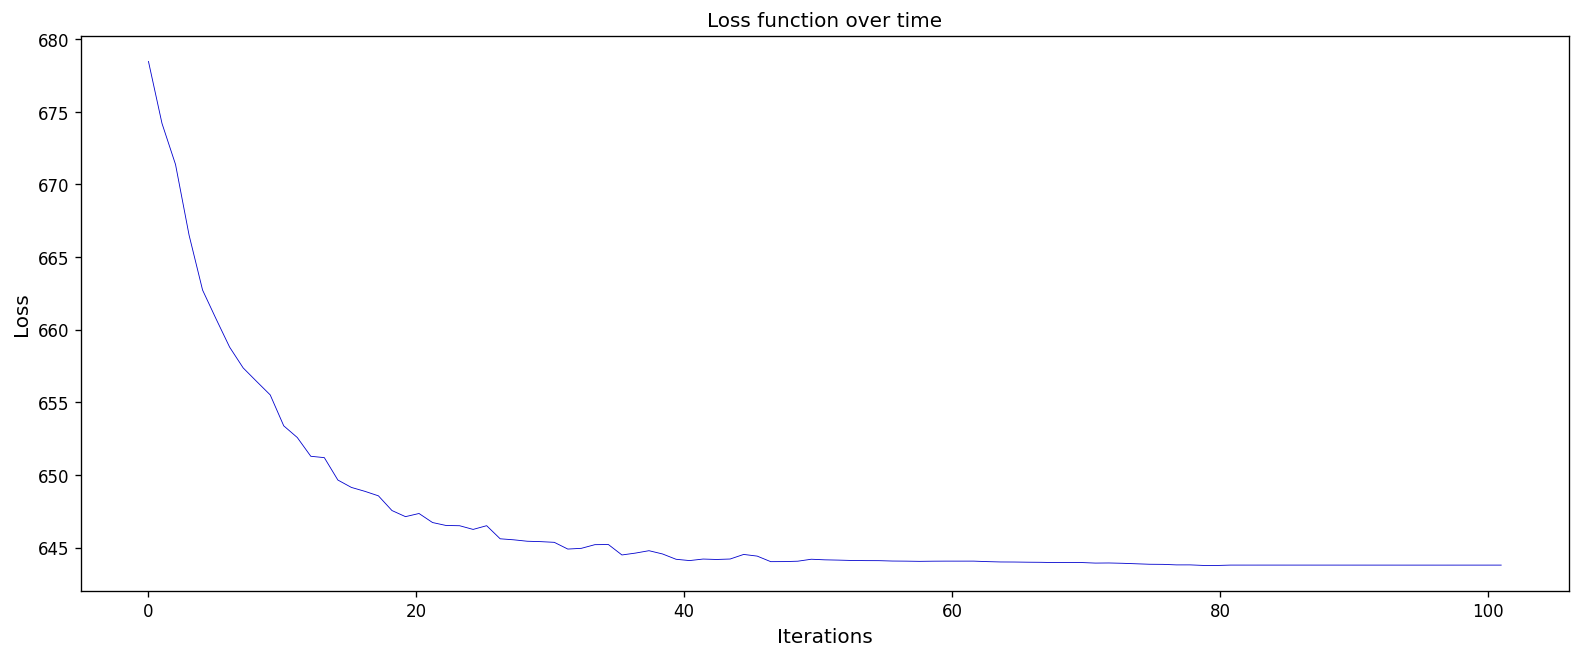

In [12]:
t = np.linspace(0, len(average_cost), len(average_cost))
fig, ax0 = plt.subplots(1, 1, figsize =(16,6), dpi = 120, sharey = True)
ax0.plot(t, average_cost, lw = 0.5, color = 'mediumblue', label = 'average_cost')
ax0.set_xlabel('Iterations', fontsize = 12)
ax0.set_ylabel('Loss', fontsize = 12)
ax0.set_title('Loss function over time', fontsize = 12)
plt.savefig('Loss_'+str(TEXT)+'.png')

[0.02779361 0.02779522 0.02778117 0.02776803 0.02774875 0.02772417
 0.02769991 0.02766947 0.0276354  0.02761254 0.02760877 0.02751714
 0.02741458 0.02733103 0.02713372 0.02699442 0.02689192 0.02630071
 0.02623842 0.02566009 0.02585189 0.0257137  0.02535731 0.02510195
 0.02495511 0.02455812 0.02377278 0.02370744 0.02295349 0.0226161
 0.02225966 0.02179993 0.02116594 0.02058153 0.02006787 0.01933125
 0.0185505  0.01768067 0.0172686  0.01719187 0.01652779 0.01570312
 0.01589004 0.01579008 0.0145921  0.01357999 0.0133948  0.01239772
 0.01202768 0.01100628 0.00971033 0.00940441 0.0073892  0.00612205
 0.00488961 0.00442864 0.00425597 0.00417903 0.00558983 0.00558989]


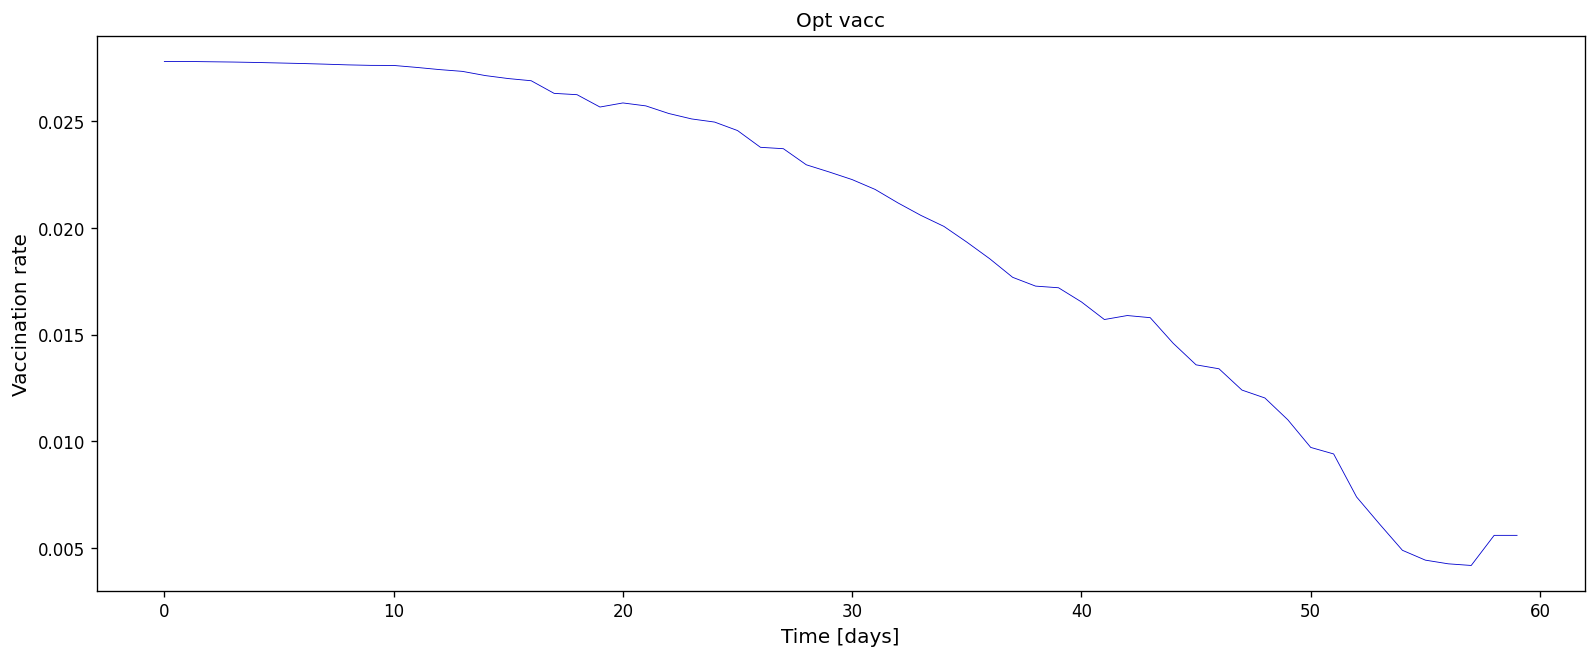

In [13]:
print(control_outs_table[1:2,:].flatten())
t = np.linspace(0, len(control_outs_table[1:2,:].flatten()),len(control_outs_table[1:2,:].flatten()))
fig, ax0 = plt.subplots(1, 1, figsize =(16,6), dpi = 120, sharey = True)
ax0.plot(control_outs_table[1:2,:].flatten(), lw = 0.5, color = 'mediumblue', label = 'average_cost')
ax0.set_xlabel('Time [days]', fontsize = 12)
ax0.set_ylabel('Vaccination rate', fontsize = 12)
ax0.set_title('Opt vacc', fontsize = 12)
plt.savefig('Opt vacc_'+str(TEXT)+'.png')